# **Reto 10: Clasificación de géneros musicales a partir de implementación propia de AdaBoost**

Inicialmente, se procede a importar los datos, ejecutar la celda a continuación para descargar el archivo correspondiente y únicamente emplear los géneros *jazz and blues* y *soul and reggae* con el fin de tener un problema de clasificación balanceado.

In [7]:
!wget http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip
!unzip msd_genre_dataset.zip
!cat msd_genre_dataset.txt | grep -E 'jazz and blues|soul and reggae' > filter_data.csv

--2019-11-14 18:19:35--  http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip
Resolving millionsongdataset.com (millionsongdataset.com)... 173.231.209.32
Connecting to millionsongdataset.com (millionsongdataset.com)|173.231.209.32|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12656044 (12M) [application/zip]
Saving to: ‘msd_genre_dataset.zip.1’

msd_genre_dataset.z 100%[===================>]  12.07M  2.94MB/s    in 4.8s    

2019-11-14 18:19:40 (2.53 MB/s) - ‘msd_genre_dataset.zip.1’ saved [12656044/12656044]

Archive:  msd_genre_dataset.zip
replace msd_genre_dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: msd_genre_dataset.txt   


**Separación y normalización de parámetros:** ejecutar la celda a continuación para aleatorizar las posiciones de los datos, de forma que el entrenamiento no se realice con los mismos datos en todas las ocasiones. Igualmente, se tienen 8350 datos, de los cuales se emplearon 1000 como datos validación, 1000 como datos de prueba y el resto fueron utilizados durante el entrenamiento. Adicionalmente, se realizó un proceso de normalización a partir de un centrado y escalamiento de los datos, esto mediante la resta de la media y la división de este resultado entre la desviación estándar.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.ensemble import AdaBoostClassifier

nombres = ['y','ID','Author','Name','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25','x26','x27','x28','x29','x30']
datos = pd.read_csv('filter_data.csv', names = nombres)
datos = datos.reindex(np.random.permutation(datos.index))
data_array = datos.values

#Se ignora el artista, la ID y el nombre de la canción
relevant_data_0 = np.array([np.delete(x, [1,2,3]) for x in data_array])

#Selección de los géneros de interés y conversión a notación binaria (jazz and blues=0, soul and reggae=1)
relevant_data_1 = relevant_data_0
for x in relevant_data_0:
  if x[0] == 'jazz and blues':
    x[0] = -1
  elif x[0] == 'soul and reggae':
    x[0] = 1

relevant_data_1 = (relevant_data_1.astype(np.float))
dataX_raw = relevant_data_1[:,1:]
#Normalización de datos
dataX = ( dataX_raw - np.mean(dataX_raw) ) / np.std(dataX_raw)
dataY = relevant_data_1[:,0]

#Separación de datos de entrenamiento, validación y de prueba
trainX_raw = relevant_data_1[2000:,1:]
trainX = dataX[2000:]
trainY = dataY[2000:]

validationX = dataX[:1000]
validationY = dataY[:1000]

testX = dataX[1000:2000]
testY = dataY[1000:2000]

# Entrenamiento y selección de modelo

Se emplearon las referencias [1] y [2] como base para el desarrollo de este modelo el cual consiste en: definir ciertos pesos para cada uno de los datos de entrenamiento (se tienen $D_i$ para cada $x_i$ con $i=1,...,n$), de modo que estos se actualicen tras cada iteración, representando el error de clasificación para la iteración anterior. Igualmente, se tendrán T iteraciones, obteniendo un clasificador (denotado $h_t$) para además asociar un valor $\alpha_t$ el cual determina su peso dentro de la decisión final dada por el signo final de la expresión: $\sum^{T}_{i=1}{\alpha_t h_t(x_i)}$.

La función realizada a continuación recibe como parámetros los datos de entrenamiento, así como el número de clasificadores a utilizar ($T$).

**Algoritmo AdaBoost**

Este método de clasificadores combinados realiza $T$ iteraciones, actualizando el valor de cada peso $D_t(i)$ siempre normalizando estos valores, de modo que $\sum_{i=1}^{n}{D_t(i)} = 1$ empleando como punto de partida para la primera iteración $D_t(i)=\frac{1}{n}, i=1,...,n$ donde $n$ corresponde al número de datos de entrenamiento.

Ahora, el proceso a seguir realiza los siguientes pasos:

1. Entrenamiento de un clasificador $h_t$ a partir de los datos pesados con $D_t$.

2. Obtención de error $\epsilon_t$ dado por la sumatoria de los pesos asociados a los datos en los cuales se cometió error de clasificación ($\sum_{i:h_t(x_i)\ne y_i} {D_t(i)}$).

3. Igualmente, se obtiene un parámetro $\alpha = \frac{1}{2} \ln{(\frac{1-\epsilon_t}{\epsilon_t})}$, el cual determinará el peso asociado a la decisión de clasificación del estimador $h_t$.

4. Se actualizan los pesos para la siguiente iteración a partir de la relación $D_{t+1} = \frac{D_t(i) exp(-\alpha_t y_i h_t(x_i))}{Z_t}$ con $Z_t=\sum^n_{i=1}{D(i)}$ con el fin de normalizar su valor. Cabe aclarar que esta relación aumenta el valor de los pesos en los cuales se cometió error de clasificación, y disminuye los correspondientes a los acertados.

Finalmente, tras obtener todos los clasificadores $h_t$ y sus pesos $\alpha_t$ correspondientes, se realiza una estimación final de la clase a partir del signo (-1 o 1) de la función $f(x_i) = \sum^T_{t=1}{\alpha_t h_t(x_i)}$.



In [0]:
def AB_propio(x, y, T):
  n = len(y)
  h_vec = []
  yPred_vec = []
  e_vec = []
  alpha_vec = []
  D_vec = []

  D_actual = np.ones(n) / n
  D_vec.append(D_actual.copy())

  for t in range(T):
    #Se emplea un clasificador de árbol de decisión con profundidad 1 y 2 nodos
    h_t = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes = 2)
    h_t.fit(x, y, sample_weight = D_actual)
    yPred = h_t.predict(x)

    errores = np.zeros(n)
    e_t = 0
    for i in range(n):
      if yPred[i] != y[i]:
        e_t += D_actual[i]

    alpha_t = (1/2)*np.log( (1 - e_t) / (e_t) )
    
    D_t = np.zeros(n)
    for i in range(n):
      D_t[i] = D_actual[i] * np.exp(-alpha_t * y[i] * yPred[i])
    Z_t = (D_t).sum()
    D_actual = D_t / Z_t

    h_vec.append(h_t)
    yPred_vec.append(yPred.copy())
    e_vec.append(e_t.copy())
    alpha_vec.append(alpha_t.copy())
    D_vec.append(D_actual.copy())
  h_vec = np.asarray(h_vec)
  yPred_vec = np.asarray(yPred_vec)
  e_vec = np.asarray(e_vec)
  alpha_vec = np.asarray(alpha_vec)
  D_vec = np.asarray(D_vec)

  y_hPred = np.zeros(n)
  for i in range(n):
    y_hPred[i] = np.sign( ( yPred_vec[:,i]*alpha_vec ).sum() )
  #print("Precisión de entrenamiento con ",T ,"estimadores:", accuracy_score(y_hPred,y))

  return h_vec, alpha_vec, accuracy_score(y_hPred,y)

def AB_predict(x, h_vec, alpha_vec):
  n = len(x)
  T = len(h_vec)
  yPred_h = []
  for t in range(T):
    yPred_h.append(h_vec[t].predict(x))
  yPred_h = np.asarray(yPred_h)
  yPred = np.zeros(n)
  for i in range(n):
    yPred[i] = np.sign( ( yPred_h[:,i]*alpha_vec ).sum() )
  return yPred

In [10]:
h_vec, alpha_vec, ac = AB_propio(trainX, trainY, 30)
yPred_val = AB_predict(validationX, h_vec, alpha_vec)

print("Precisión de entrenamiento: ", ac)
print("Precisión de validación: ", accuracy_score(yPred_val, validationY))

Precisión de entrenamiento:  0.8420472440944882
Precisión de validación:  0.822


# Selección de modelo
Posteriormente, se realiza una variación del número de estimadores, con el fin de observar el progreso de la precisión en datos de entrenamiento y validación con respecto al aumento del parámetro $T$.

In [0]:
train_ac = []
val_ac = []
max_val_ac = 0
max_val_ac_T = 0
T_min = 1
T_max = 100

T = range(T_min, T_max)

for i in range(len(T)):
  h_vec, alpha_vec, prec_train = AB_propio(trainX, trainY, T[i])
  yPred_val = AB_predict(validationX, h_vec, alpha_vec)

  #print("Número de clasificadores=",T[i])
  prec_val = accuracy_score(yPred_val,validationY)
  #print("->Precisión en datos de entrenamiento:", prec_train)
  #print("->Precisión en datos de validación:", prec_val)
  train_ac.append(prec_train)
  val_ac.append(prec_val)
  if prec_val > max_val_ac:
    max_val_ac = prec_val
    AB_best_h_vec = h_vec
    AB_best_alpha_vec = alpha_vec
    max_val_ac_T = T[i]

-->Mejor clasificador con T= 76 y precisión en datos de prueba: 0.806


Text(0.5, 1.0, 'Entrenamiento de modelo AdaBoost')

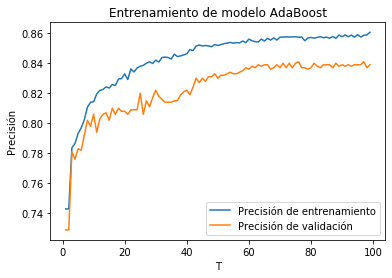

In [14]:
yPred_test = AB_predict(testX, AB_best_h_vec, AB_best_alpha_vec)
test_ac = accuracy_score(yPred_test, testY)
print("-->Mejor clasificador con T=",max_val_ac_T,"y precisión en datos de prueba:", test_ac)

fig, ax = plt.subplots()
ax.plot(T, train_ac, label='Precisión de entrenamiento')
ax.plot(T, val_ac, label='Precisión de validación')
ax.legend()
plt.xlabel("T")
plt.ylabel("Precisión")
plt.title("Entrenamiento de modelo AdaBoost")

**Conclusiones**

-Al realizar una variación del número de clasificadores empleado (T) se observó una relación directa entre la precisión del modelo en los datos de entrenamiento y de validación, ya que no se produjo *overfitting* en ninguno de los casos evaluados (la precisión de validación no se vio reducida significativamente a partir de algún valor de T).

-Sin embargo, se sugiere determinar un valor óptimo de T (en este caso, se podría escoger un valor entre 150 y 200, ya que la precisión de validación no aumenta considerablemente para valores mayores) con el fin de evitar *overfitting* en algún problema distinto al observado en este caso, ya que se tuvo un gran conjunto de datos de entrenamiento en un problema balanceado y de clasificación binaria.

# Referencias

[1] AdaBoost: Implementation and intuition. Disponible en línea en: https://xavierbourretsicotte.github.io/AdaBoost.html

[2] Lozano, Fernando. Clasificadores Combinados. Universidad de los Andes (2019)

[3] Sklearn: DecisionTreeClassifier. Disponible en línea en: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.fit


In [0]:
a = [2, 3, 4]
b = a.copy()
a.append(2)
print(a)
print(b)

[2, 3, 4, 2]
[2, 3, 4]
